# Similarity Based Methods

## Index Based

In [1]:
import os
import sys
sys.path.append(f"{os.getcwd()}/..")                
from utils import draw_graph, DATA_DIR

### Resource Allocation

[(1, 2, 0.5), (2, 5, 0.5), (3, 4, 0.5)]


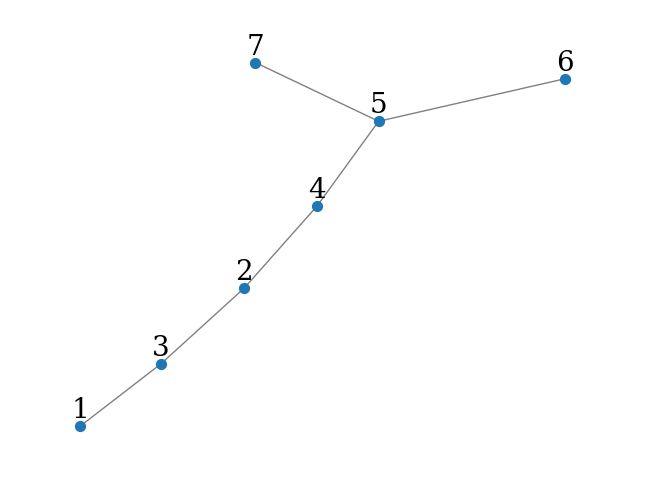

In [2]:
import networkx as nx
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)
preds = nx.resource_allocation_index(G,[(1,2),(2,5),(3,4)])
print(list(preds))
draw_graph(G)

### Jaccard Coefficient

[(1, 2, 0.5), (2, 5, 0.25), (3, 4, 0.3333333333333333)]


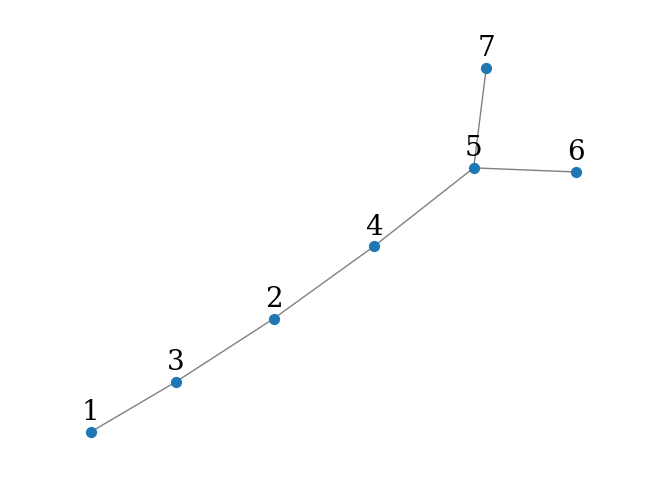

In [3]:
import networkx as nx
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)
preds = nx.jaccard_coefficient(G,[(1,2),(2,5),(3,4)])
print(list(preds))
draw_graph(G)

## Community Based

### Community Common Neighbor

[(1, 2, 2), (2, 5, 1), (3, 4, 1)]


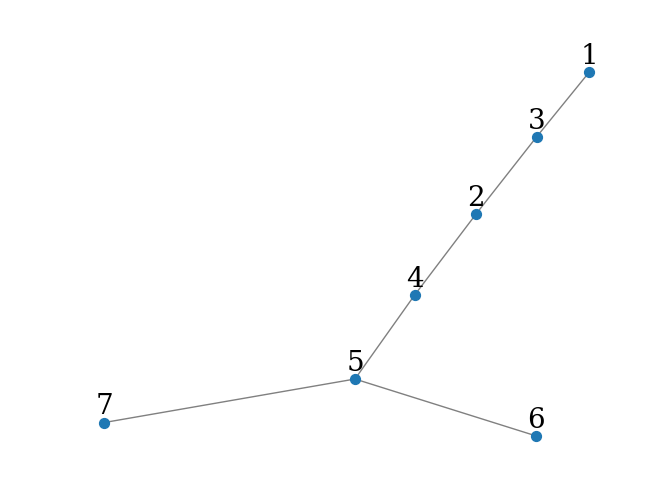

In [4]:
import networkx as nx
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)

G.nodes[1]["community"] = 0
G.nodes[2]["community"] = 0
G.nodes[3]["community"] = 0

G.nodes[4]["community"] = 1
G.nodes[5]["community"] = 1
G.nodes[6]["community"] = 1
G.nodes[7]["community"] = 1
preds = nx.cn_soundarajan_hopcroft(G,[(1,2),(2,5),(3,4)])
print(list(preds))
draw_graph(G)

### Community Common Neighbor

[(1, 2, 0.5), (2, 5, 0), (3, 4, 0)]


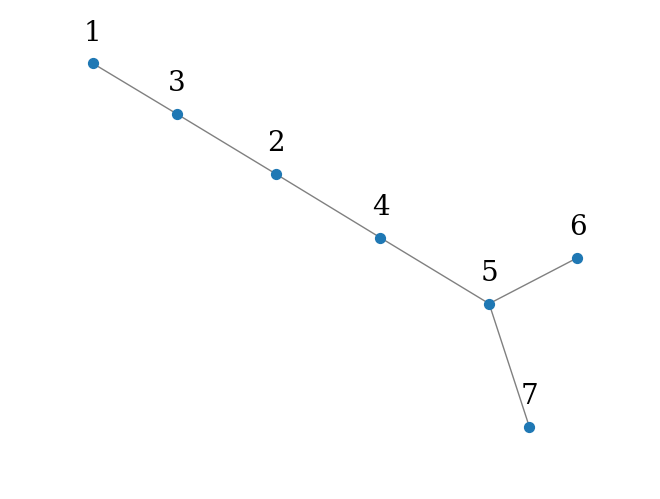

In [5]:
import networkx as nx
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)

G.nodes[1]["community"] = 0
G.nodes[2]["community"] = 0
G.nodes[3]["community"] = 0

G.nodes[4]["community"] = 1
G.nodes[5]["community"] = 1
G.nodes[6]["community"] = 1
G.nodes[7]["community"] = 1
preds = nx.ra_index_soundarajan_hopcroft(G,[(1,2),(2,5),(3,4)])
print(list(preds))
draw_graph(G)

## Embedding based

In [6]:
import requests
from zipfile import ZipFile
from io import BytesIO
import shutil
import tarfile

url = 'https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz'

tmp_file = DATA_DIR / os.path.basename(url)

with open(tmp_file, "wb") as fid:
    r = requests.get(url, allow_redirects=True)
    fid.write(r.content)

with tarfile.open(tmp_file, "r:gz") as tar:
    tar.extractall(DATA_DIR)

In [7]:
import networkx as nx
import pandas as pd

edgelist = pd.read_csv(os.path.join(DATA_DIR, "cora", "cora.cites"), sep='\t', header=None, names=["target", "source"])
G = nx.from_pandas_edgelist(edgelist)

In [8]:
from stellargraph.data import EdgeSplitter

edgeSplitter = EdgeSplitter(G)
graph_test, samples_test, labels_test = edgeSplitter.train_test_split(
    p=0.1, method="global"
)

2024-08-16 09:27:09.398363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-16 09:27:09.398381: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


** Sampled 527 positive and 527 negative edges. **


2024-08-16 09:27:15.201749: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-08-16 09:27:15.201776: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-08-16 09:27:15.201791: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pelican): /proc/driver/nvidia/version does not exist
2024-08-16 09:27:15.202117: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
edgeSplitter = EdgeSplitter(graph_test, G)
graph_train, samples_train, labels_train = edgeSplitter.train_test_split(
    p=0.1, method="global"
)

** Sampled 475 positive and 475 negative edges. **


In [10]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder

node2vec = Node2Vec(graph_train)
model = node2vec.fit()
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)
train_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_train]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████| 10/10 [01:10<00:00,  7.04s/it]


In [11]:
test_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_test]

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(train_embeddings, labels_train);

In [13]:
from sklearn import metrics

y_pred = rf.predict(test_embeddings)

print('Precision:', metrics.precision_score(labels_test, y_pred))
print('Recall:', metrics.recall_score(labels_test, y_pred))
print('F1-Score:', metrics.f1_score(labels_test, y_pred))

Precision: 0.8640167364016736
Recall: 0.7836812144212524
F1-Score: 0.8218905472636816
